### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [2]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

prepare finished.


label_B: torch.Size([3])  sos,condBD: torch.Size([6, 1024])
si 0 pn:1 x:torch.Size([6, 1, 1024]) blocks:16
logits_BlV: torch.Size([3, 1, 4096]) idx_Bl: torch.Size([3, 1])
si 1 pn:2 x:torch.Size([6, 4, 1024]) blocks:16
logits_BlV: torch.Size([3, 4, 4096]) idx_Bl: torch.Size([3, 4])
si 2 pn:3 x:torch.Size([6, 9, 1024]) blocks:16
logits_BlV: torch.Size([3, 9, 4096]) idx_Bl: torch.Size([3, 9])
si 3 pn:4 x:torch.Size([6, 16, 1024]) blocks:16
logits_BlV: torch.Size([3, 16, 4096]) idx_Bl: torch.Size([3, 16])
si 4 pn:5 x:torch.Size([6, 25, 1024]) blocks:16
logits_BlV: torch.Size([3, 25, 4096]) idx_Bl: torch.Size([3, 25])
si 5 pn:6 x:torch.Size([6, 36, 1024]) blocks:16
logits_BlV: torch.Size([3, 36, 4096]) idx_Bl: torch.Size([3, 36])
si 6 pn:8 x:torch.Size([6, 64, 1024]) blocks:16
logits_BlV: torch.Size([3, 64, 4096]) idx_Bl: torch.Size([3, 64])
si 7 pn:10 x:torch.Size([6, 100, 1024]) blocks:16
logits_BlV: torch.Size([3, 100, 4096]) idx_Bl: torch.Size([3, 100])
si 8 pn:13 x:torch.Size([6, 169, 

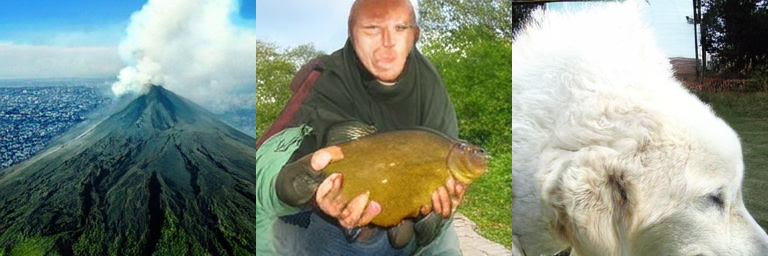

In [3]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 10 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 0, 222)#, 90, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
# chw.show()
chw
